In [15]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, explained_variance_score, max_error, mean_absolute_percentage_error, r2_score, mean_poisson_deviance
from sklearn.linear_model import lasso_path
pd.set_option("display.max_rows", None, "display.max_columns", None)

Getting the data

In [16]:
data = pd.read_csv('http://data.insideairbnb.com/united-states/dc/washington-dc/2022-03-19/data/listings.csv.gz')

In [17]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7403 non-null   int64  
 1   listing_url                                   7403 non-null   object 
 2   scrape_id                                     7403 non-null   int64  
 3   last_scraped                                  7403 non-null   object 
 4   name                                          7402 non-null   object 
 5   description                                   7282 non-null   object 
 6   neighborhood_overview                         4777 non-null   object 
 7   picture_url                                   7403 non-null   object 
 8   host_id                                       7403 non-null   int64  
 9   host_url                                      7403 non-null   o

Columns with missing data

In [19]:
listings_na = data.isna().sum()
listings_na[listings_na.values > 0].sort_values(ascending=False)

bathrooms                       7403
calendar_updated                7403
neighbourhood_group_cleansed    7403
license                         6210
host_about                      2950
neighborhood_overview           2626
neighbourhood                   2626
host_response_time              2010
host_response_rate              2010
review_scores_value             1780
review_scores_location          1778
review_scores_checkin           1778
review_scores_accuracy          1776
review_scores_communication     1775
review_scores_cleanliness       1775
reviews_per_month               1714
review_scores_rating            1714
last_review                     1714
first_review                    1714
host_acceptance_rate            1652
bedrooms                         725
host_neighbourhood               501
beds                             150
description                      121
host_location                     13
bathrooms_text                    12
minimum_minimum_nights             3
m

Price column

In [48]:
data.describe(include="all")["price"]

count     7326.000000
unique            NaN
top               NaN
freq              NaN
mean       170.035081
std        147.903249
min          9.000000
25%         85.000000
50%        125.000000
75%        200.000000
max       1200.000000
Name: price, dtype: float64

Converting price values from object to float

In [21]:
data["price"] = data["price"].apply(lambda x: x.replace("$", "")) # Remove dollar sign
data["price"] = data["price"].apply(lambda x: x.replace(",", "")) # Remove thousand seperator
data["price"] = data["price"].astype("float") # Cast the column into type float
data.describe(include="all")["price"]

count      7403.000000
unique             NaN
top                NaN
freq               NaN
mean        197.079157
std         456.804058
min           0.000000
25%          85.000000
50%         127.000000
75%         202.000000
max       24999.000000
Name: price, dtype: float64

In [22]:
print("99% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99)))
# Since 99% entries have a price that is lower than 761 , we choose to remove the rest as outliers.
# We would like to create a new column "price_range" for visualisations later on. The choice of cutoff points (e.g. 20, 40, 60, etc) is inspired by the quartiles of column "price".

99% properties have a price lower than  1200.00


<AxesSubplot:ylabel='Frequency'>

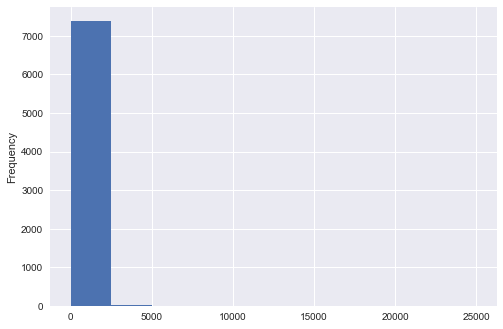

In [23]:
data.price.plot.hist()
#This data needs to be trimmed due to outliers

<AxesSubplot:ylabel='Frequency'>

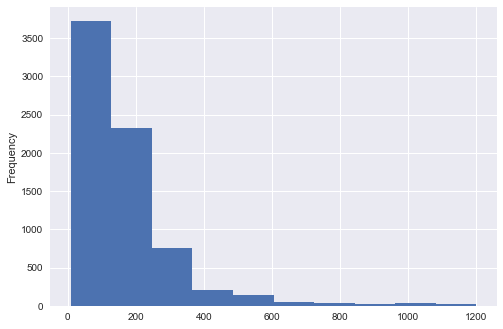

In [24]:
data = data[(data.price <= np.percentile(data["price"], 99)) & (data.price > 0)] # Exclude outliers
data.price.plot.hist()

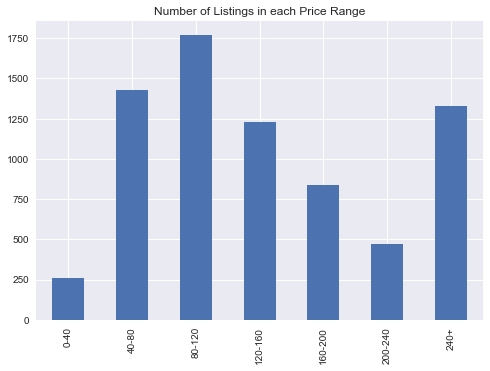

In [25]:
plt.style.use("seaborn")
price_range = pd.cut(data["price"], 
                     bins=[0, 40, 80, 120, 160, 200, 240, data["price"].max()], 
                     labels=["0-40", "40-80", "80-120", "120-160", "160-200", "200-240", "240+"])
data["price_range"] = price_range 
data["price_range"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of Listings in each Price Range")
plt.show()

In [26]:
selected = []
host = ['host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_identity_verified']
location = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']
geo = ["latitude", "longitude"]
condition = ['property_type', 'room_type', 'bed_type', 'amenities', 'cleaning_fee', 'minimum_nights']
review = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
size = ['space', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']
others = ['instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

#Plots about hosts

In [27]:
data.describe(include="all")[host]

,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified
count,7325,6835,7325.000000,7325.000000,7326,7325
unique,2,198,NaN,NaN,272,2
top,f,Northwest Washington,NaN,NaN,"['email', 'phone']",t
freq,5228,741,NaN,NaN,1157,6056
mean,NaN,NaN,136.849420,136.849420,NaN,NaN
std,NaN,NaN,504.596977,504.596977,NaN,NaN
min,NaN,NaN,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,1.000000,1.000000,NaN,NaN
50%,NaN,NaN,2.000000,2.000000,NaN,NaN
75%,NaN,NaN,8.000000,8.000000,NaN,NaN


In [32]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(8*n_cols, 6*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

ValueError: Number of rows must be a positive integer, not 3.0

<Figure size 576x396 with 0 Axes>

In [33]:
index = []
i=0
for col in host:
  if data[col].nunique() >= 10:
    index.append(i)
    i=i+1
  else:
    i=i+1
    continue
host = np.delete(host, index)

In [34]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(8*n_cols, 6*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

ValueError: Number of rows must be a positive integer, not 1.0

<Figure size 576x396 with 0 Axes>

#Adjusting host data

In [35]:
data["host_is_superhost"] = data["host_is_superhost"].replace(np.NAN, "f")
data["host_identity_verified"] =data["host_identity_verified"].replace(np.NAN, "f")

Now we can perform a statistical test: t-test

In [36]:
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
# Define multicomp function
def multicomp(target_name, group_name, data):
    if (np.nan in data[target_name]) | (np.nan in data[group_name]):
        print("Please remove NaN in target variable or group variable!")
    elif (data[target_name].nunique() == 1) | (data[group_name].nunique() == 1):
        print("There is only one unique value in target variable or group variable.")
    elif data[group_name].nunique() == 2:
        mod = MultiComparison(data[target_name], data[group_name])
        comp = mod.allpairtest(stats.ttest_ind)
        print(comp[0])
    else:
        mod = MultiComparison(data[target_name], data[group_name])
        print(mod.tukeyhsd().summary())
multicomp("price", "host_is_superhost", data)
multicomp("price", "host_identity_verified", data)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
     f      t 2.3566 0.0185    0.0185   True
--------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
     f      t 0.1971 0.8438    0.8438  False
--------------------------------------------


Both null hypotesis were not rejected, so no value of those above shall be used

Let's handle host verifications

In [37]:
data["host_ver_types"] = data["host_verifications"].apply(lambda x: x[1:-1].replace("\'", "").split(", "))
#data["host_ver_types"]
#Ten kod sprawia, że z ['email', 'phone', 'reviews'] robi się [email, phone, reviews]

In [38]:
data["host_ver_type_counts"] = data["host_ver_types"].apply(lambda x: len(x))
#Ten kod sprawia, że zliczamy ilość typów weryfikacji w danej nieruchomości
#data["host_ver_type_counts"] 

<AxesSubplot:>

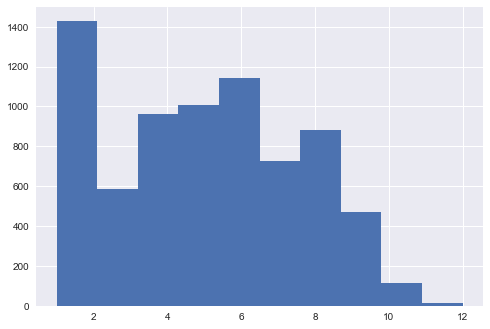

In [39]:
data["host_ver_type_counts"].hist()

In [40]:
host_ver_types = []
for i in data["host_ver_types"]:
    host_ver_types += i

#host_ver_types
#Ten kod iteruje nam po wszystkich typach weryfikacji i dodaje do nowo utworzonej listy (uwzględniając potęrzną ilość duplikatów)

In [41]:
host_ver_types_freq = dict((x, host_ver_types.count(x)) for x in set(host_ver_types))
host_ver_types_freq
#Ten kod sprawdza, ile było weryfikacji daną drogą i imieszcza to w słowniku. Jakby co, to set, też jest zamknięty w {} i nie można zmienić jego wartości

{'': 2,
 'manual_online': 55,
 'government_id': 4162,
 'jumio': 2866,
 'selfie': 1972,
 'manual_offline': 108,
 'phone': 7314,
 'email': 6862,
 'facebook': 1007,
 'kba': 1780,
 'offline_government_id': 3130,
 'work_email': 1583,
 'on': 1,
 'reviews': 4728,
 'identity_manual': 1746,
 'sent_id': 4,
 'google': 440}

In [42]:
host_ver_types_freq = pd.DataFrame.from_dict(host_ver_types_freq, orient="index")
#Robimy Dataframe z tego słownika powyżej
host_ver_types_freq.reset_index(inplace=True)
#Dokonujemy reset index
host_ver_types_freq.columns = ["Verification", "Frequency"]
#Zmieniamy nazwy kolumn
host_ver_types_freq = host_ver_types_freq.sort_values(by="Frequency", ascending=True)
#Szeregujemy
host_ver_types_freq

,Verification,Frequency
12,on,1
0,,2
15,sent_id,4
1,manual_online,55
5,manual_offline,108
16,google,440
8,facebook,1007
11,work_email,1583
14,identity_manual,1746
9,kba,1780


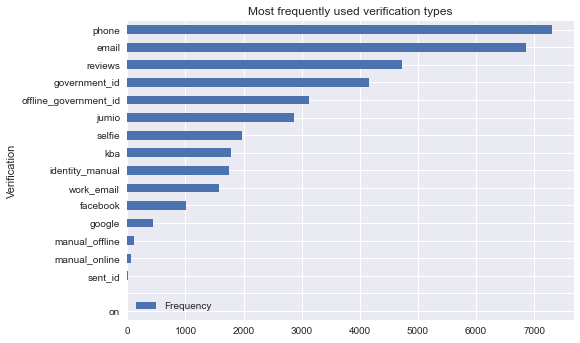

In [43]:
host_ver_types_freq.plot.barh(x="Verification", y="Frequency")
plt.title("Most frequently used verification types")
plt.show()
#Rysujemy wykres

#Geoplot

In [44]:
import plotly.graph_objects as go
import plotly.express as px
from plotly import tools
from plotly.offline import plot as plotoffline
import seaborn as sns

Creating a dataset

In [45]:
geo = data[['latitude', 'longitude', 'price', 'price_range']]
geo = geo.sort_values("price", ascending=True) # This sorting is necessary for the color scale to work properly. 
geo.describe()

,latitude,longitude,price
count,7326.000000,7326.000000,7326.000000
mean,38.911071,-77.016247,170.035081
std,0.025339,0.030250,147.903249
min,38.820280,-77.107210,9.000000
25%,38.898170,-77.035767,85.000000
50%,38.909870,-77.018730,125.000000
75%,38.923695,-76.997337,200.000000
max,38.997820,-76.910950,1200.000000


Simple scatter plot

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

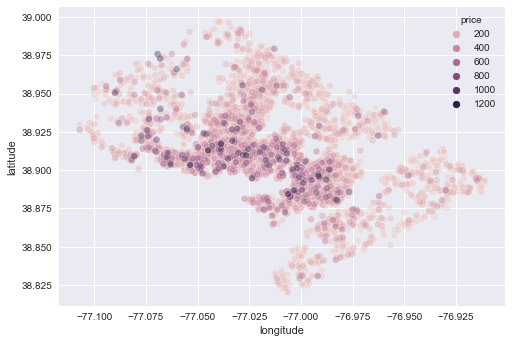

In [46]:
sns.scatterplot(x="longitude", 
                y="latitude", 
                hue="price", 
                data=geo, 
                alpha=0.4)

Below we have created map with marked prices from several ranges

In [ ]:
# # Map plot
# from textwrap import wrap

# px.set_mapbox_access_token("pk.eyJ1IjoiZ2F3cm9ubiIsImEiOiJjbDNzeXllNWkxMnl4M2psdHRtZGZkODh0In0.hSntC8Rp50ICzYyvo606nA") # Replace XXX with your Mapbox Token

# #Token created here: https://account.mapbox.com/access-tokens 
# #I think, that simmilar map could be generated via one of books from python - ćwiczenia
# fig = px.scatter_mapbox(geo, 
#                         lat="latitude", 
#                         lon="longitude", 
#                         color="price_range",
#                         color_continuous_scale=px.colors.sequential.Aggrnyl,# Na tej stronie można sobie wybierać różne skale kolorów https://plotly.com/python/builtin-colorscales/
#                         opacity=0.9, 
#                         zoom=10)
# fig.show()

In [ ]:
data.neighbourhood_cleansed.unique()

Top 5 places in Geneva are:

Jet d’Eau: 46.20781920740878, 6.1559458078945575

UN: 46.22722304906608, 6.14029219999106

Geneva flower clock & Jardin Anglais: 46.20651003559838, 6.151676906400394

Parc Des Eaux Vives: 46.210636056069006, 6.167380187678211

St Pierre Cathedral: 46.20170590767383, 6.148515900004998

Calcuate the distance bwteen the listing and mianat tractions in Geneva

In [ ]:
# Formula to calculate distances
from math import sin, cos, sqrt, atan2, radians
def distance(lat1, lat2, lon1, lon2):
    R = 6373.0
    rlat1 = radians(lat1)
    rlat2 = radians(lat2)
    rlon1 = radians(lon1)
    rlon2 = radians(lon2)
    rdlon = rlon2 - rlon1
    rdlat = rlat2 - rlat1
    a = sin(rdlat / 2)**2 + cos(rlat1) * cos(rlat2) * sin(rdlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
# Top locations in Riga
toploc = {"Jet": [46.20781920740878, 6.1559458078945575], 
          "UN": [46.22722304906608, 6.14029219999106], 
          "Jardin": [46.20651003559838, 6.151676906400394], 
          "Parc": [46.210636056069006, 6.167380187678211], 
          "Cathedral": [46.20170590767383, 6.148515900004998]}

In [ ]:
toploc = pd.DataFrame.from_dict(toploc)
toploc_trans = toploc.transpose()
toploc_trans.columns = ["latitude", "longitude"]

In [ ]:
# # Draw a plot with top locations

# fig = px.scatter_mapbox(toploc_trans, 
#                         lat="latitude", 
#                         lon="longitude", 
#                         zoom=10)
# fig.show()

In [ ]:
# Construct distance columns
dist = []
for col in toploc.columns:
    data["dist_"+col] = data.apply(lambda x: distance(x.latitude, toploc[col][0], x.longitude, toploc[col][1]), axis=1)
    dist.append("dist_"+col)

#W liście dist znajdują się po prostu nazwy wszystkich hot lokacji
#W tej pętli for zliczamy odległości między danym miejscem, a jedną z top lokalizacji. Ta odległość wpisana została do jednej z 5 nowych kolumn - reprezentujących odległości do top lokacji

Below 5 last columns

In [ ]:
data.iloc[:5, -5:]

In [ ]:
n_cols = 3
n_rows = np.ceil((len(dist)+1)/n_cols)
i = 1
plt.figure(figsize=(8*n_cols, 6*n_rows))
for distance in dist:
  # Ważne, zeby zanotować, że distance przyjmuje nazwy nowo utworzonych kolumn
  plt.subplot(n_rows, n_cols, i)
  sns.scatterplot(x=distance, y="price", data=data, alpha=0.3)
  plt.title("Correlation between price and "+distance)
  i=i+1
  print("The correlation between price and "+distance+ " is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data[distance].isna()][distance], data[-data[distance].isna()]["price"])))
  # W tym princie jest stats.pearsonr. Odpowiada to za policzenie korelacji Pearsona w odniesieniu do ceny - jest to funkcja ze scipy
plt.show()

Corellation is high everywhere and p value is always 0

In [ ]:
# Tutaj robimy sobie kolejny zestaw kolumn związanych z dystansem (z suffixem _close) - tutaj są one jednak skategoryzowane - True, jesli jest blisko i false, jesli jest daleko
for distance in dist:
   data[distance+"_close"] = (data[distance] < data[distance].median())
   print(data.groupby(distance+"_close").mean()["price"])

#Następnie dodajemy ostratnia kolumnę, w której dajemy werdykt na podstawie mediany, czy dany obiekt można uznać, za dobrze położony
data["good_distance"] = data.apply(lambda x: any([x.dist_Jet_close, x.dist_UN_close, x.dist_Jardin_close, x.dist_Parc_close, x.dist_Cathedral_close]), axis=1)

We can see histogram below, which informs us, that mean price of locations with small distance to top 5 attractions in the city is higher.

In [ ]:
data.groupby("good_distance").mean()["price"].plot(kind="bar")
plt.show()

In [ ]:
data.iloc[:5, -6:]

We can append then this criterion to our selected table:

In [ ]:
selected.append("good_distance")
selected

#Neighbourhood statistics

We would also like to check the popularity and price level at each neighbourhood of Geneva.

In [ ]:
# Top popular nerghbourhoods
neighbourhood_group_pop = pd.DataFrame(data["neighbourhood_cleansed"].value_counts())
neighbourhood_group_pop.head(5)
#Tutaj zliczamy, ile jest lokali w danych dzielniach

In [ ]:
# Average price of each neighbourhood
neighbourhood_group_price = data.groupby("neighbourhood_cleansed").mean()["price"]
neighbourhood_group_price = pd.DataFrame(neighbourhood_group_price)
neighbourhood_group_price.sort_values("price", ascending=False).head(5)
#Tutaj zliczamy sredną cenę w danej dzielni - jeszcze posortowane

In [ ]:
# Create neighbourhood stats
neighbourhood_stat = pd.merge(neighbourhood_group_pop, 
                              neighbourhood_group_price, 
                              how="inner", left_index=True, right_index=True)
neighbourhood_stat.reset_index(inplace=True)
neighbourhood_stat.columns = ["neighbourhood_cleansed", "count_properties", "avg_price"]
neighbourhood_stat = neighbourhood_stat.sort_values(by="count_properties", ascending=False)
neighbourhood_stat.head(10)
#Tutaj mamy obie te listy zestawione

In [ ]:
#Addition of filter, which consists of neighbourhoods with at least XXXX properties
neighbourhood_stat_limited = neighbourhood_stat[neighbourhood_stat['count_properties']>40]

In [ ]:
#Drawing a plot with relation - No. of properties vs avg price in selected neighbourhood
fig = plt.figure()
ax = neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(14, 6))
neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

#Condition statistics

We would also like to check the impact of conditions.

!!!Uwaga. Z racji, iż u nas jest inny zestaw parametrów, niż w Berlinie, to lista condition została podmieniona!!!!

In [ ]:
condition = ['property_type', 'room_type', 'amenities', 'minimum_nights', 'maximum_nights']

In [ ]:
data[condition].head()

property type

In [ ]:
# Tutaj zliczamy ile jest danych typów lokali i przypisujemy temu typowi avg cenę
prop_type_avg_price = data.groupby("property_type").mean()["price"]
prop_type_count_listings = data["property_type"].value_counts()
prop_type_stat = pd.merge(prop_type_count_listings, prop_type_avg_price, how="inner", left_index=True, right_index=True)
prop_type_stat.columns = ["count_prop", "avg_price"]
prop_type_stat.sort_values(by="count_prop", ascending=False).head(10)

In [ ]:
#Drawing a plot with relation - No. of properties vs avg price in selected property type
prop_type_stat_limited = prop_type_stat[prop_type_stat['count_prop']>20] #Trzeba było ograniczyć liczbe rodzajów lokli
fig = plt.figure()
ax = prop_type_stat_limited['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(28, 6))
prop_type_stat_limited['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Room type

In [ ]:
# Tutaj zliczamy ile jest danych typów pokoi i przypisujemy temu typowi avg cenę
room_type_avg_price = data.groupby("room_type").mean()["price"]
room_type_count_listings = data["room_type"].value_counts()
room_type_stat = pd.merge(room_type_count_listings, room_type_avg_price, how="inner", left_index=True, right_index=True)
room_type_stat.columns = ["count_prop", "avg_price"]
room_type_stat.sort_values(by="count_prop", ascending=False).head(10)

In [ ]:
#Drawing a plot with relation - No. of properties vs avg price in selected room type
fig = plt.figure()
ax = room_type_stat['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(10, 6))
room_type_stat['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Entire apartment has a significant higher price than a private room. Therefore we take it into our model.

In [ ]:
data["is_entire_apt"] = data["room_type"]=="Entire home/apt"
selected.append("is_entire_apt")

Amendities

In [ ]:
data["amenities"].head()

In [ ]:
data["amenities"] =data["amenities"].apply(lambda x: x[1:-1].replace("\'", "").replace(' "', '').replace('"', '').split(","))
data["amenities"].head()

In [ ]:
# Tutaj rozpisujemy wszystkie występujące amenities
amenity_types = []
for i in data["amenities"]:
    amenity_types += i
#amenity_types

In [ ]:
#Wyliczamy, ile jest danych amenity types i szeregujemy je po descending
amenity_types_freq = dict((x, amenity_types.count(x)) for x in set(amenity_types))
amenity_types_freq = pd.DataFrame.from_dict(amenity_types_freq, orient="index")
amenity_types_freq.reset_index(inplace=True)
amenity_types_freq.columns = ["Amenity", "Frequency"]
amenity_types_freq = amenity_types_freq.sort_values(by="Frequency", ascending=False)
amenity_types_freq.head(25)

In [ ]:
# Tysujemy plota z 20 najbardziej popularnymi
amenity_types_freq.head(25).plot.barh(x="Amenity", y="Frequency")
plt.title("Top20 most frequent amenity types")
plt.show()

90%+ listings have the Top3 features: kitchen, Essentials and heatLong term stays allowed. Therefore they won't have a huge impact on price. We choose to focuse on features that ~50% listings have. They are:

Hot Water

Hair dryer

Dedicated workspace

Washer

Cooking basics

Dishes and silverware

Refrigerator

Shampoo

Elevator

Bed linens

Cofee maker

TV

Oven

Stove

Microwave

In [ ]:
#Tworzymy nowe kolumny z true/False, czy są tam amenitsy, które nas interesują
data["with_Hot_Water"] = data["amenities"].apply(lambda x: 'Hot Water' in x)
data["with_Hair_dryer"] =data["amenities"].apply(lambda x: 'Hair dryer' in x)
data["with_Dedicated_workspace"] = data["amenities"].apply(lambda x: 'Dedicated workspace' in x)
data["with_Washer"] = data["amenities"].apply(lambda x: 'Washer' in x)
data["with_Cooking_basics"] = data["amenities"].apply(lambda x: 'Cooking basics' in x)
data["with_Dishes_and_silverware"] =data["amenities"].apply(lambda x: 'Dishes and silverware' in x)
data["with_Refrigerator"] = data["amenities"].apply(lambda x: 'Refrigerator' in x)
data["with_Shampoo"] = data["amenities"].apply(lambda x: 'Shampoo' in x)
data["with_Elevator"] = data["amenities"].apply(lambda x: 'Elevator' in x)
data["with_Bed_linens"] =data["amenities"].apply(lambda x: 'Bed linens' in x)
data["with_Coffee_maker"] = data["amenities"].apply(lambda x: 'Coffee maker' in x)
data["with_TV"] = data["amenities"].apply(lambda x: 'TV' in x)
data["with_Oven"] =data["amenities"].apply(lambda x: 'Oven' in x)
data["with_Stove"] = data["amenities"].apply(lambda x: 'Stove' in x)
data["with_Microwave"] = data["amenities"].apply(lambda x: 'Microwave' in x)

In [ ]:
data.iloc[:10, -15:]

In [ ]:
#Important!!!!! I have changed this one - it shall be reviewed!!!!!!!!!!!!!!!!!
for amenit in data.iloc[:, -15:].columns:
  print(amenit)
  print(multicomp("price", amenit, data))

We can reject null hypotesis for:

Hair dryer

Dedicated workspace

Washer

Shampoo

Cofee maker

In [ ]:
for i in ["with_Hair_dryer", "with_Dedicated_workspace", "with_Washer", "with_Shampoo", "with_Coffee_maker"]:
    selected.append(i)

In [ ]:
selected

Minimum nights

In [ ]:
data["minimum_nights"].describe()

In [ ]:
for i in range(2, 10):
  data['min_nights_greater_than_{}'.format(i)] = data["minimum_nights"] > i
  multicomp("price", 'min_nights_greater_than_{}'.format(i), data=data)
data.iloc[:10, -8:]

We can saee, that p value is on proper value after min 7 nights - so it shall not be taken under consideration, due to clear negative impact after this value

Lets see about maximum nights

In [ ]:
data["maximum_nights"].describe()

it is hard to estimate something here, so lets ged rid of this max nights criterion

#Review statistics

In [ ]:
data["review_scores_rating"].hist()

In [ ]:
# Scatter plot between review score and price
import seaborn as sns
import scipy.stats as stats
sns.regplot(x="review_scores_rating", y="price", data=data[data["review_scores_rating"]>=3])
plt.title("Price vs Review Score Rating")
plt.show()
print("The correlation between review score and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data["review_scores_rating"].isna()]["review_scores_rating"], data[-data["review_scores_rating"].isna()]["price"])))

Check the correlation between price and other scores

In [ ]:
for col in review:
    print(("The pearson correlation coefficient between " + col + " and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.").format(stats.pearsonr(data[-data[col].isna()][col],data[-data[col].isna()]["price"])))

Here we can see, that corelation is significant for:

review_scores_cleanliness

review_scores_checkin

review_scores_location

In [ ]:
for i in ["review_scores_cleanliness", "review_scores_checkin", "review_scores_location"]:
    selected.append(i)

In [ ]:
selected

#Size of apartment

Look at size-related variables

In [ ]:
#Need to adjust data to Riga provided columns
size = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
data[size].head(10)

In [ ]:
data['bathrooms'].describe()

it occour, that there are no valuable info in bathrooms column

In [ ]:
data['bathrooms_text'].unique()

But we count find something interesting in 'bathrooms_text column'

In [ ]:
data['bathrooms'] = np.where(data['bathrooms_text'].str.contains('half',case=False, na=False), 0.5, 
                          data['bathrooms_text'].str.split().str[0]).astype(np.float64)
data[size].head(10)

Check the correlation between number of accommodates and price

In [ ]:
data["accommodates"].describe()

In [ ]:
data["accommodates"].hist()

In [ ]:
data.groupby("accommodates").mean()["price"].plot(kind="bar")
plt.title("Avg. Price grouped by Number of Accommodates")
plt.show()
print("The pearson correlation coefficient between ther number of acoommodates and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data["accommodates"], data["price"])))

Accommodates can be used as a proxy of space and has sig. correlation with price.

In [ ]:
selected.append("accommodates")
selected

Check the correlation bewteen accommodates and other size variables

In [ ]:
size_variables = data[size]
size_corr = size_variables.corr()
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(size_corr, cmap=colormap, annot=True, fmt=".4f")

Conclusion: the variable "accommodates" is highly correlated with "beds" and "bedrooms", so it is sufficient to include only accommodates into our model.

nevertheless, due to bedrooms is more important factor, when we are concluding buying apartment - i will add this factor too.

In [ ]:
selected.append("bedrooms")
selected

#Other conditions

In [ ]:
# I had to limit it due to Riga data
others = ['instant_bookable']
data[others].head()

In [ ]:
data["instant_bookable"].value_counts()
multicomp("price", "instant_bookable", data)
data.groupby("instant_bookable").mean()["price"].plot(kind="bar")
plt.title("Avg. Price split by Instant Bookable Policy")
plt.show()

We can add instant bookable then

In [ ]:
selected.append("instant_bookable")
selected

We have all selected values!!!

#Feature engineering

In [ ]:
data[selected].info()

Convert string variables into categorical variables

In [ ]:
data["instant_bookable"] = data["instant_bookable"]=="t"

In [ ]:
for col in data[selected].select_dtypes("bool").columns:
    data[col] = data[col].astype("int")

In [ ]:
data[selected].info()

Standardisation

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledFeatures = sc.fit_transform(data[selected])
scaledFeatures

#XGB

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X = scaledFeatures
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [ ]:
# Xgb with best parameters
xgb_clf = xgb.XGBRegressor(n_estimators=100, max_depth=3)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print("R^2 score is: {0: .4f}".format(r2_score(y_test, y_test_pred)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

We can compare now resuts to predictions

In [ ]:
results_compared= {'Real values': y_test,
                   'Predicted_Values': y_test_pred}
results_compared = pd.DataFrame(results_compared)
#results_compared

We can use Lasso, to choose best parameters due to Lasso algotythm

#Lasso

Creating table to be used

In [ ]:
data_subset = data.loc[:, selected + ['price']]
data_subset.dropna(inplace=True)
data_subset.head()

Further preparation of data - Standardization

In [ ]:
X = data_subset.loc[:,selected]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

In [ ]:
# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

We can remove then: instant_bookable, review_scores_checkin, review_scores_location

In [ ]:
selected2 = selected.copy()
selected2

In [ ]:
selected2.remove('with_Coffee_maker')
selected2.remove('review_scores_checkin')
selected2.remove('review_scores_location')
selected2.remove('instant_bookable')
selected2.remove('with_Dedicated_workspace')
selected2

try Lasso again

In [ ]:
X = data_subset.loc[:,selected2]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

In [ ]:
# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected2[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

Now its much better. At the end lets remove accomodates value, sice it is srtrongly connected with bedrooms

In [ ]:
selected2_no_accomodates = selected2.copy()
selected2_no_accomodates.remove('accommodates')
selected2_no_accomodates

In [ ]:
# It will work better in the future, when it is rearanged:
selected2_no_accomodates = ['bedrooms', 'good_distance', 'is_entire_apt', 'with_Hair_dryer', 'with_Shampoo', 'review_scores_cleanliness']

#XGB Repeated

In [ ]:
from sklearn.preprocessing import StandardScaler
sc2 = StandardScaler()
scaledFeatures2 = sc2.fit_transform(data[selected2])
scaledFeatures2

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X2 = scaledFeatures2
y = data["price"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf2 = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [ ]:
# Xgb with best parameters
xgb_clf2 = xgb.XGBRegressor(n_estimators=80, max_depth=3)
xgb_clf2.fit(X_train2, y_train2)
y_test_pred2 = xgb_clf2.predict(X_test2)
print("R^2 score is: {0: .4f}".format(r2_score(y_test2, y_test_pred2)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test2, y_test_pred2))))

Last try - without accomodates

In [ ]:
from sklearn.preprocessing import StandardScaler
sc2_no_accomodates = StandardScaler()
scaledFeatures2_no_accomodates = sc.fit_transform(data[selected2_no_accomodates])
scaledFeatures2_no_accomodates

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X2_no_accomodates = scaledFeatures2_no_accomodates
y = data["price"]
X_train2_no_accomodates, X_test2_no_accomodates, y_train2_no_accomodates, y_test2_no_accomodates = train_test_split(X2_no_accomodates, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf2_no_accomodates = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train2_no_accomodates, y_train2_no_accomodates)
print(grid_search.best_params_)

In [ ]:
# Xgb with best parameters
xgb_clf2_no_accomodates = xgb.XGBRegressor(n_estimators=80, max_depth=3)
xgb_clf2_no_accomodates.fit(X_train2_no_accomodates, y_train2_no_accomodates)
y_test_pred2_no_accomodates = xgb_clf2_no_accomodates.predict(X_test2_no_accomodates)
print("R^2 score is: {0: .4f}".format(r2_score(y_test2_no_accomodates, y_test_pred2_no_accomodates)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test2_no_accomodates, y_test_pred2_no_accomodates))))

We will use this set of data for further predictions

#Shapley

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
X = data[selected]
shap_values = explainer.shap_values(X)
X.iloc[0,:]

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
explainer2 = shap.TreeExplainer(xgb_clf2)
X2 = data[selected2]
shap_values2 = explainer2.shap_values(X2)
X2.iloc[0,:]

In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X2.iloc[0,:])

In [ ]:
explainer2_no_accomodates = shap.TreeExplainer(xgb_clf2_no_accomodates)
X2_no_accomodates = data[selected2_no_accomodates]
shap_values2_no_accomodates = explainer2_no_accomodates.shap_values(X2_no_accomodates)
X2_no_accomodates.iloc[0,:]

In [ ]:
shap.initjs()
shap.force_plot(explainer2_no_accomodates.expected_value, shap_values2_no_accomodates[0,:], X2_no_accomodates.iloc[0,:])

#Linear Regression

In [ ]:
selected

In [ ]:
selected2

In [ ]:
selected2_no_accomodates

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('price ~ good_distance + is_entire_apt + with_Hair_dryer + with_Dedicated_workspace + with_Washer + with_Shampoo + with_Coffee_maker + review_scores_cleanliness + review_scores_checkin + review_scores_location + accommodates + bedrooms + instant_bookable', data=data).fit()

print(model.summary())

In [ ]:
model2 = smf.ols('price ~ good_distance + is_entire_apt + with_Hair_dryer + with_Washer + with_Shampoo + review_scores_cleanliness + accommodates + bedrooms', data=data).fit()

print(model2.summary())

In [ ]:
model2_no_accomodates = smf.ols('price ~ good_distance + is_entire_apt + with_Hair_dryer + with_Washer + with_Shampoo + review_scores_cleanliness + bedrooms', data=data).fit()

print(model2_no_accomodates.summary())

W can see, that we can remoove Washer, due to low p

In [ ]:
model_final = smf.ols('price ~ bedrooms + good_distance + is_entire_apt + with_Hair_dryer + with_Shampoo + review_scores_cleanliness', data=data).fit()

print(model_final.summary())

#Ceteris paribus

Lets calculate number of bedrooms

In [ ]:
['good_distance', 'is_entire_apt', 'with_Hair_dryer', 'with_Shampoo', 'review_scores_cleanliness']
data_temp = pd.DataFrame({"bedrooms" : [x for x in range(30)]})
data_temp['good_distance'] = 1
data_temp['is_entire_apt'] = 1
data_temp['with_Hair_dryer'] = 1
data_temp['with_Shampoo'] = 1
data_temp['review_scores_cleanliness'] = 4.8
data_temp

data_temp.head()

In [ ]:
#To jest potrzebne, bo ten xgb zmienia nazwy atrybutów na f0, f1... Tutaj się do tego odwołujemy i zmieniamy mu nazwy spowrotem na prawidłowe
xgb_clf2_no_accomodates.get_booster().feature_names = ['bedrooms', 'good_distance', 'is_entire_apt', 'with_Hair_dryer', 'with_Shampoo', 'review_scores_cleanliness']
xgb_clf2_no_accomodates.get_booster().feature_names

In [ ]:
xgb_clf2_no_accomodates.get_booster().feature_names

In [ ]:
data_subset = data.loc[:, selected2_no_accomodates + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)

#Predict
predictions_temp = xgb_clf2_no_accomodates.predict(data_temp)

#Plot
plt.scatter(x=data_temp.bedrooms, y=predictions_temp)
plt.show()

Here we can see, that really big raise is with 3 bedrooms, but it may be hard to buy - 2 bedrooms are also good